In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def hel_fn(name: str): # Dateinamen -> Szenarionamen
    scenario = name.split("_")[-1].split(".")[0]
    if 'CWE' in scenario:
        scenario = name.split("_")[-2].replace("-sorted", "") + name.split("_")[-1].split(".")[0]
    return scenario

def help(s: str): # Dateinamen -> STIDE Konfiguration
    spl = s.split('_')
    return (f"{spl[2]}{spl[6]}")

def intersect(scen: list,triv: list):  # scen - triv
    tem = []
    for element in scen:
        if element not in triv:
            tem.append(element)
    return ','.join(tem)

In [ ]:
df_kmeans = pd.read_csv("kmeans5True.csv")
df_dbscan = pd.read_csv("dbscan5true.csv")
df_birch = pd.read_csv("birch5true.csv")
ges_5true = df_kmeans[['scenario','percent_classified']].set_index('scenario').join(df_dbscan[['scenario','percent_classified']].set_index('scenario'), rsuffix="_dbscan").join(df_birch[['scenario','percent_classified']].set_index('scenario'), rsuffix="_birch").rename(columns={'percent_classified': "kmeans", "percent_classified_dbscan": "dbscan", "percent_classified_birch": "birch"})
all_names_scenarios = list(ges_5true.index)
all_names_scenarios.remove('CVE-2012-2122')

In [49]:
df = pd.read_csv("../results.csv")
df["n"]=df["scenario"].str.split("_").str[2]
df["t"]=df["scenario"].str.split("_").str[6]
df["n"]=df["n"].map(int)
df["scenario"]=df["scenario"].map(hel_fn)

In [59]:
df[df["scenario"] == "CVE-2014-0160"]

scenario  alarms  false  true  n      t
1   CVE-2014-0160      18     18     0  3  False
14  CVE-2014-0160     131     11   120  3   True
27  CVE-2014-0160       2      2     0  5  False
40  CVE-2014-0160     132     12   120  5   True
53  CVE-2014-0160       6      6     0  7  False
66  CVE-2014-0160     206     14   192  7   True

In [178]:
df = df[df["true"]>0]
df["ratio"] = df["true"] / df['ges']
df.groupby("full_spec").mean()

ges      false        true     ratio
full_spec                                             
3False     320.000000  17.888889  302.111111  0.922505
3True      549.875000   7.125000  542.750000  0.956474
5False     148.000000  23.333333  124.666667  0.734990
5True      538.800000  11.400000  527.400000  0.957577
7False     149.300000  17.900000  131.400000  0.739469
7True      462.916667  18.166667  444.750000  0.920788

In [70]:
df = pd.read_csv("../../../../LIDDS/overview/results.csv", names=["filename", "ges", "false", "true"])
df["full_spec"]=df["filename"].map(help)
df["scenario"]=df["filename"].map(hel_fn)
df = df.fillna(0)
df["true"]=df["true"].map(int)
dft = df[df["true"]==0].groupby("full_spec")["scenario"].transform(lambda x: ','.join(x))
dftwo = df[df["true"]==0].groupby("full_spec").count()["filename"]
dftwo = dftwo.to_frame().rename(columns={"filename": "triviale Szenarien"})
puh = df[df["true"]==0].groupby('full_spec')["scenario"].transform(lambda x: ','.join(x)).drop_duplicates()
dftwo["scenarios"] = puh.to_numpy()
# .drop("ges", axis=1).drop("false", axis=1).drop("true", axis=1)

In [71]:
df2 = pd.read_csv("auswertung_feature_ohne_clustersize_mit_szenarien.csv")
df2 = df2.join(dftwo, on="full_spec")
df2["n_scenarios"] = df2["n_scenarios"] - df2["triviale Szenarien"] # auskommentieren für unbereinigte Ergebnisse
df2['scenarios'] = df2[['group_concat(DISTINCT(scenario))','scenarios']].apply(lambda x: [i for i in x[0].split(",") if i not in x[1].split(",")], axis=1)
df2.loc[df2['n_scenarios']<0,"n_scenarios"] +=1 # sonderfälle bei dbscan weil ein szenario nur 2 Alarme hat und nicht geclustert werden kann
df2 = df2.drop('group_concat(DISTINCT(scenario))', axis=1)

full_spec  n_scenarios  \
4069     7False            3   
4070     7False            3   
13218    7False            2   
13219    7False            2   
13220    7False            2   
13221    7False            2   
13222    7False            2   
13223    7False            2   
13224    7False            2   
13225    7False            2   
13226    7False            2   
13227    7False            2   

                                        enabled_features algorithm   eps  \
4069   syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
4070   syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
13218  syscall_histogram, path_length, syscall_timing...    dbscan  0.35   
13219  syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
13220  syscall_histogram, path_length, syscall_timing...    dbscan  0.25   
13221  syscall_histogram, path_length, syscall_timing...    dbscan  0.35   
13222  syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
13223  syscall_histogram, path_length, syscall_timing...    dbscan  0.25   
13224  syscall_histogram, syscall_timing_avg, syscall...    dbscan  0.20   
13225  syscall_histogram, syscall_timing_avg, syscall...    dbscan  0.25   
13226  syscall_histogram, syscall_timing_min, syscall...    dbscan  0.20   
13227  syscall_histogram, syscall_timing_min, syscall...    dbscan  0.25   

       min_samples  triviale Szenarien  \
4069             2                   3   
4070             2                   3   
13218            2                   3   
13219            2                   3   
13220            2                   3   
13221            2                   3   
13222            2                   3   
13223            2                   3   
13224            2                   3   
13225            2                   3   
13226            2                   3   
13227            2                   3   

                                     scenarios  
4069   [CVE-2019-5418, Juice-Shop, EPSCWE-434]  
4070   [CVE-2019-5418, Juice-Shop, EPSCWE-434]  
13218              [CVE-2019-5418, Juice-Shop]  
13219              [CVE-2019-5418, Juice-Shop]  
13220              [CVE-2019-5418, Juice-Shop]  
13221              [CVE-2019-5418, Juice-Shop]  
13222              [CVE-2019-5418, Juice-Shop]  
13223              [CVE-2019-5418, Juice-Shop]  
13224              [CVE-2019-5418, Juice-Shop]  
13225              [CVE-2019-5418, Juice-Shop]  
13226              [CVE-2019-5418, Juice-Shop]  
13227              [CVE-2019-5418, Juice-Shop]

Index(['Vorkommen in Konfigurationen'], dtype='object')


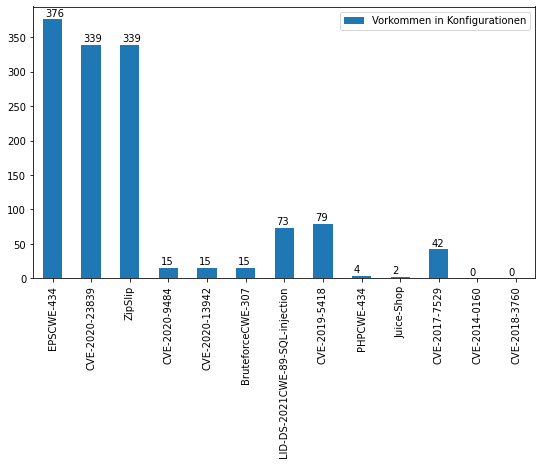

In [72]:
count_scenarios = {}
for i in df2[df2["n_scenarios"]==3]['scenarios']:
    for f in i:
        try:
            count_scenarios[f] += 1
        except KeyError:
            count_scenarios[f] = 1
for i in all_names_scenarios:
    try:
        count_scenarios[i]
    except KeyError:
        count_scenarios[i] = 0
df_scenarios_that_got_clustered = pd.DataFrame.from_dict(count_scenarios, orient='index', columns=['Vorkommen in Konfigurationen'])
ax = df_scenarios_that_got_clustered.plot(kind='bar', figsize=(9,5))
print(df_scenarios_that_got_clustered.columns)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height()+5))

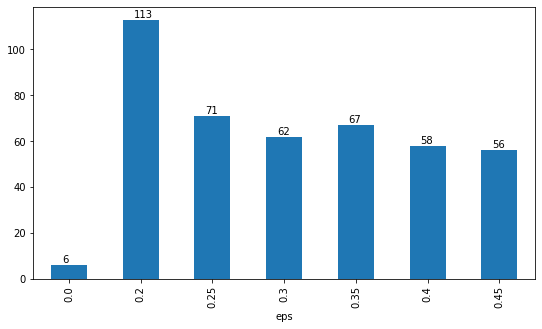

In [73]:
ax = df2[df2['n_scenarios']==3].groupby('eps')['n_scenarios'].count()
ax = ax.plot(kind='bar', figsize=(9,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

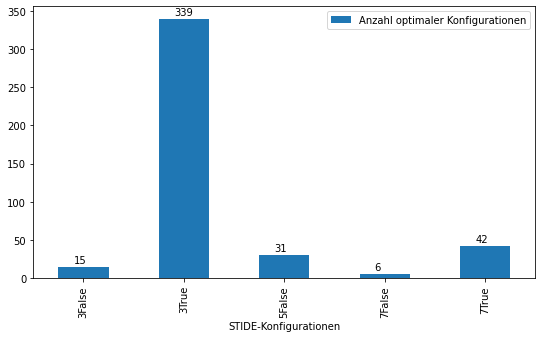

In [74]:

out = df2[df2['n_scenarios']==3].groupby('full_spec')['enabled_features'].count().to_frame()
out = out.rename(columns={'enabled_features': "Anzahl optimaler Konfigurationen"})
out.index.names = ["STIDE-Konfigurationen"]
ax = out.plot(kind="bar", figsize=(9,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.15, p.get_height()+5))

In [187]:

out = df2[df2['n_scenarios']==3].groupby('enabled_features')['full_spec'].count().to_frame()
out = out.rename(columns={'full_spec': "Anzahl optimaler Konfigurationen"})
out.index.names = ["Features"]
ind = out.sort_values("Anzahl optimaler Konfigurationen", ascending=False).head(10).index
#ax = out.plot(kind="bar", figsize=(9,5))
#for p in ax.patches:
#    ax.annotate(str(p.get_height()), (p.get_x()+0.15, p.get_height()+5))

In [91]:
feature_dict = {}
counter = 1
for i in out.index:
    for x in i.split(", "):
        try:
            feature_dict[x]
        except KeyError:
            feature_dict[x] = f"({counter})"
            counter+=1

{'path_length': '(1)',
 'syscall_timing_avg': '(2)',
 'syscall_timing_max': '(3)',
 'trigram_histogram': '(4)',
 'trigram_match': '(5)',
 'syscall_timing_min': '(6)',
 'syscall_histogram': '(7)'}

In [92]:
def rename(s: str) -> str: # benennt Features um in Zahlencodierung
    li = []
    for i in s.split(", "):
        li.append(feature_dict[i])
    return ", ".join(li)

out.index = out.index.map(rename)
out.sort_values("Anzahl optimaler Konfigurationen", ascending=False).head(10)

Anzahl optimaler Konfigurationen
Features                                            
(7), (2)                                          14
(7), (1), (2)                                     14
(1), (2)                                          10
(7), (1)                                          10
(1), (3)                                          10
...                                              ...
(7), (3), (5)                                      1
(7), (2), (5)                                      1
(7), (1), (6), (5)                                 1
(7), (2), (3), (5)                                 1
(7), (1), (2), (5)                                 1

[86 rows x 1 columns]

In [78]:
dict_feature_histo = {}
def count_feat(s:str):
    for i in s.split(", "):
        try:
            dict_feature_histo[i]+=1
        except KeyError:
            dict_feature_histo[i]=1

out.index.map(count_feat)
dict_feature_histo

{'(1)': 50, '(2)': 43, '(3)': 39, '(4)': 64, '(5)': 42, '(6)': 37, '(7)': 47}

In [79]:
out = df2.groupby("n_scenarios")["full_spec"].count().to_frame()
out = out.rename(columns={"full_spec": "Anzahl Konfigurationen"})
out

Anzahl Konfigurationen
n_scenarios                        
0                             20372
1                             16381
2                              4724
3                               433

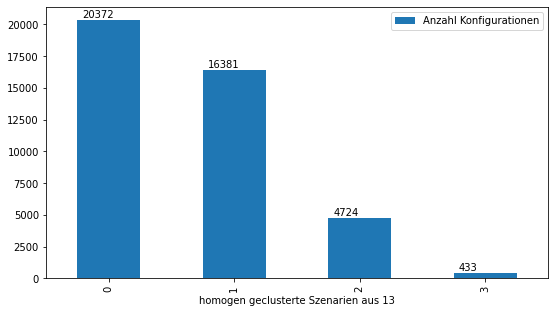

In [80]:
ax = out.plot(kind="bar", figsize=(9,5))
ax.set_xlabel("homogen geclusterte Szenarien aus 13")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+ 0.04, p.get_height() + 200))

In [189]:
out

Anzahl optimaler Konfigurationen
Features                                                                            
path_length                                                                        6
path_length, syscall_timing_avg                                                   10
path_length, syscall_timing_avg, syscall_timing...                                 4
path_length, syscall_timing_avg, syscall_timing...                                 6
path_length, syscall_timing_avg, syscall_timing...                                 6
...                                                                              ...
syscall_timing_min, syscall_timing_max, trigram...                                 6
syscall_timing_min, trigram_histogram                                              6
syscall_timing_min, trigram_histogram, trigram_...                                 6
trigram_histogram                                                                  4
trigram_histogram, trigram_match                                                   6

[86 rows x 1 columns]

In [93]:
df2[df2["enabled_features"] == "syscall_histogram, path_length, syscall_timing_avg"]

full_spec  n_scenarios  \
1499     5False            3   
1500     5False            3   
1501     5False            3   
1502     5False            3   
1503     5False            3   
...         ...          ...   
38202     7True            1   
38203     7True            1   
38204     7True            1   
38205     7True            1   
38206     7True            1   

                                        enabled_features algorithm   eps  \
1499   syscall_histogram, path_length, syscall_timing...     birch  0.20   
1500   syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
1501   syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
1502   syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
1503   syscall_histogram, path_length, syscall_timing...    dbscan  0.20   
...                                                  ...       ...   ...   
38202  syscall_histogram, path_length, syscall_timing...    dbscan  0.25   
38203  syscall_histogram, path_length, syscall_timing...    dbscan  0.25   
38204  syscall_histogram, path_length, syscall_timing...    dbscan  0.30   
38205  syscall_histogram, path_length, syscall_timing...    dbscan  0.30   
38206  syscall_histogram, path_length, syscall_timing...    dbscan  0.30   

       min_samples  triviale Szenarien  \
1499             9                   4   
1500             2                   4   
1501             3                   4   
1502             4                   4   
1503             5                   4   
...            ...                 ...   
38202            8                   1   
38203            9                   1   
38204            7                   1   
38205            8                   1   
38206            9                   1   

                                               scenarios  
1499   [EPSCWE-434, LID-DS-2021CWE-89-SQL-injection, ...  
1500   [EPSCWE-434, LID-DS-2021CWE-89-SQL-injection, ...  
1501   [EPSCWE-434, LID-DS-2021CWE-89-SQL-injection, ...  
1502   [EPSCWE-434, LID-DS-2021CWE-89-SQL-injection, ...  
1503   [EPSCWE-434, LID-DS-2021CWE-89-SQL-injection, ...  
...                                                  ...  
38202                                    [CVE-2019-5418]  
38203                                    [CVE-2019-5418]  
38204                                    [CVE-2019-5418]  
38205                                    [CVE-2019-5418]  
38206                                    [CVE-2019-5418]  

[330 rows x 8 columns]

In [118]:
results = pd.read_csv("../results.csv")
results['full_spec'] = results["scenario"].map(help)
results['scenario'] = results["scenario"].map(hel_fn)
results

scenario  alarms  false  true full_spec
0                 BruteforceCWE-307      22      3    19    3False
1                     CVE-2014-0160      18     18     0    3False
2                     CVE-2017-7529     119    119     0    3False
3                     CVE-2018-3760     301     22   279    3False
4                     CVE-2019-5418      25     25     0    3False
..                              ...     ...    ...   ...       ...
73  LID-DS-2021CWE-89-SQL-injection    1071      1  1070     7True
74                       EPSCWE-434     456      9   447     7True
75                       Juice-Shop      99     16    83     7True
76                       PHPCWE-434     247      3   244     7True
77                          ZipSlip    1190     62  1128     7True

[78 rows x 5 columns]

In [127]:
all_alarms = pd.read_csv("all.csv", low_memory=False)
all_alarms['full_spec'] = all_alarms['n'].map(str) + all_alarms['t'].map(lambda x: "True" if x else "False")
all_alarms = all_alarms.drop("n", axis=1).drop("t", axis=1)

algorithm                                   enabled_features  \
0         dbscan                                        path_length   
1         dbscan                                        path_length   
2         dbscan                                        path_length   
3         dbscan                                        path_length   
4         dbscan                                        path_length   
...          ...                                                ...   
607954     birch  syscall_histogram, path_length, syscall_timing...   
607955     birch  syscall_histogram, path_length, syscall_timing...   
607956     birch  syscall_histogram, path_length, syscall_timing...   
607957     birch  syscall_histogram, path_length, syscall_timing...   
607958     birch  syscall_histogram, path_length, syscall_timing...   

        percent_classified   eps  min_samples  clusters       scenario  \
0                      0.0  0.20            2         2     Juice-Shop   
1                      0.0  0.20            3         2     Juice-Shop   
2                      0.0  0.20            4         2     Juice-Shop   
3                      0.0  0.20            5         2     Juice-Shop   
4                      0.0  0.20            6         2     Juice-Shop   
...                    ...   ...          ...       ...            ...   
607954                 1.0  0.25            9         3  CVE-2017-7529   
607955                 1.0  0.30            9         4  CVE-2017-7529   
607956                 1.0  0.35            9         4  CVE-2017-7529   
607957                 1.0  0.40            9         5  CVE-2017-7529   
607958                 1.0  0.45            9         4  CVE-2017-7529   

       full_spec  
0          5True  
1          5True  
2          5True  
3          5True  
4          5True  
...          ...  
607954    3False  
607955    3False  
607956    3False  
607957    3False  
607958    3False  

[607959 rows x 8 columns]

In [188]:
all_alarms[all_alarms['percent_classified']==1.0]

algorithm                                   enabled_features  \
36576     dbscan                                        path_length   
36577     dbscan                                        path_length   
36578     dbscan                                        path_length   
36579     dbscan                                        path_length   
36580     dbscan                                        path_length   
...          ...                                                ...   
607954     birch  syscall_histogram, path_length, syscall_timing...   
607955     birch  syscall_histogram, path_length, syscall_timing...   
607956     birch  syscall_histogram, path_length, syscall_timing...   
607957     birch  syscall_histogram, path_length, syscall_timing...   
607958     birch  syscall_histogram, path_length, syscall_timing...   

        percent_classified   eps  min_samples  clusters  \
36576                  1.0  0.20            2         2   
36577                  1.0  0.20            3         2   
36578                  1.0  0.20            4         2   
36579                  1.0  0.20            5         2   
36580                  1.0  0.20            6         2   
...                    ...   ...          ...       ...   
607954                 1.0  0.25            9         3   
607955                 1.0  0.30            9         4   
607956                 1.0  0.35            9         4   
607957                 1.0  0.40            9         5   
607958                 1.0  0.45            9         4   

                               scenario full_spec  
36576   LID-DS-2021CWE-89-SQL-injection    7False  
36577   LID-DS-2021CWE-89-SQL-injection    7False  
36578   LID-DS-2021CWE-89-SQL-injection    7False  
36579   LID-DS-2021CWE-89-SQL-injection    7False  
36580   LID-DS-2021CWE-89-SQL-injection    7False  
...                                 ...       ...  
607954                    CVE-2017-7529    3False  
607955                    CVE-2017-7529    3False  
607956                    CVE-2017-7529    3False  
607957                    CVE-2017-7529    3False  
607958                    CVE-2017-7529    3False  

[181096 rows x 8 columns]

In [130]:
full_df = all_alarms.merge(results, on=["scenario", "full_spec"])
full_df['true_ratio'] = full_df['true'] / full_df["alarms"]
full_df

scenario
BruteforceCWE-307                  int64
CVE-2017-7529                      int64
CVE-2019-5418                      int64
CVE-2020-13942                     int64
CVE-2020-23839                     int64
CVE-2020-9484                      int64
EPSCWE-434                         int64
LID-DS-2021CWE-89-SQL-injection    int64
PHPCWE-434                         int64
ZipSlip                            int64
dtype: object


<AxesSubplot:xlabel='scenario', ylabel='enabled_features'>

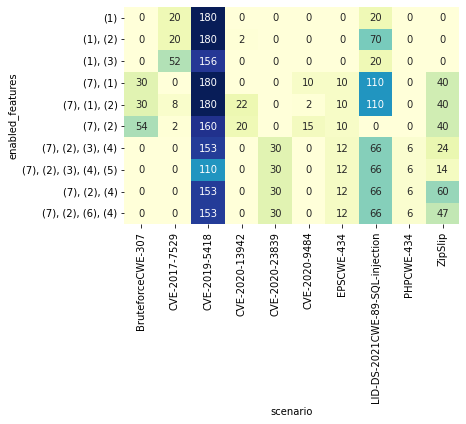

In [229]:
filtered = full_df[(full_df['percent_classified']==1.0)  & (full_df['true']>0) & (full_df['enabled_features'].isin(list(ind)))] #
filtered["enabled_features"] = filtered['enabled_features'].map(rename)
cross = pd.crosstab(filtered.enabled_features, filtered.scenario).astype(int)
print(cross.dtypes)
import seaborn as sns
sns.heatmap(cross, cmap="YlGnBu", annot=True, cbar=False, fmt='g')

<AxesSubplot:xlabel='false'>

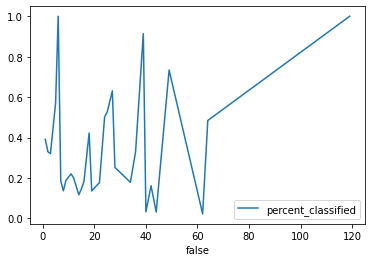

In [169]:
lesst = full_df[full_df['false'] < 128]
lesst[['false', 'percent_classified']].groupby('false').mean().plot(kind='line')

In [156]:
full_df[['false', 'percent_classified']].groupby("false").mean()

percent_classified
false                    
1                0.391054
2                0.329961
3                0.319969
5                0.571481
6                1.000000
7                0.184906
8                0.136113
9                0.187551
11               0.220106
12               0.199565
14               0.116669
15               0.145424
16               0.183249
18               0.422298
19               0.135822
22               0.177077
24               0.501962
25               0.525766
27               0.630909
28               0.252095
34               0.178258
36               0.329327
39               0.913702
40               0.031908
42               0.161274
44               0.031343
49               0.733780
62               0.021973
64               0.484209
119              1.000000
235              1.000000
258              1.000000
277              1.000000
296              1.000000
313              1.000000
327              1.000000
331              1.000000
426              1.000000
528              1.000000

<AxesSubplot:xlabel='true_ratio'>

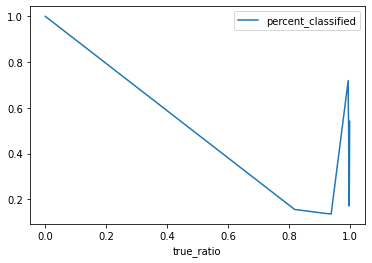

In [151]:
df_onepoint = all_alarms[all_alarms['full_spec']=="3True"].merge(results, on=["scenario", "full_spec"])
df_onepoint['true_ratio'] = df_onepoint['true'] / df_onepoint["alarms"]
df_onepoint[['true_ratio', 'percent_classified']].groupby("true_ratio").mean().plot(kind="line")